# Proyek Klasifikasi Gambar: 5 Flower Types Classification Dataset
- **Nama:** Danny Budiman
- **Email:** danny.budiman@gmail.com
- **ID Dicoding:** danny.budiman@gmail.com

## Import Semua Packages/Library yang Digunakan

In [1]:
# Import Library
import os

repo_name = "Proyek-Klasifikasi-Gambar"
repo_url = "https://github.com/dannybudiman/Proyek-Klasifikasi-Gambar.git"

# Cek apakah repo sudah ada
if not os.path.exists(repo_name):
    # Clone repo (jalan di Kaggle Notebook)
    !git clone {repo_url}

# Berpindah ke folder repo (diluar blok if)
%cd {repo_name}
# Tarik update jika diperlukan
!git pull
%cd ..



Cloning into 'Proyek-Klasifikasi-Gambar'...
remote: Enumerating objects: 29392, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 29392 (delta 1), reused 0 (delta 0), pack-reused 29388 (from 4)
Receiving objects: 100% (29392/29392), 614.54 MiB | 41.33 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (5008/5008), done.
/kaggle/working/Proyek-Klasifikasi-Gambar
Already up to date.
/kaggle/working


## Data Preparation

### Data Loading

In [2]:
import os
import tensorflow as tf

# Path ke folder dataset
dataset_path = "Proyek-Klasifikasi-Gambar/data/flower_images"

# Load dataset dengan image_dataset_from_directory
batch_size = 32
img_height = 180
img_width = 180

# Tentukan 2 kelas yang benar-benar tersedia
selected_classes = ["Sunflower", "Tulip"]

# Muat hanya 2 kelas tersebut
ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int",
    class_names=selected_classes
)


2025-07-30 12:20:27.622964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753878027.858162      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753878027.922580      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2000 files belonging to 2 classes.


I0000 00:00:1753878041.511256      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Data Preprocessing

#### Split Dataset

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras import Sequential

# Path ke folder dataset
dataset_path = "Proyek-Klasifikasi-Gambar/data/flower_images"

# Parameter dasar
batch_size = 32
img_height = 180
img_width = 180

# Tentukan 2 kelas yang tersedia
selected_classes = ["Sunflower", "Tulip"]

# Load dataset hanya dengan 2 kelas
ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int",
    class_names=selected_classes
)

# Hitung jumlah batch dan lakukan split (70% train, 20% val, 10% test)
total_batches = tf.data.experimental.cardinality(ds_filtered).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.2 * total_batches)
test_size = total_batches - train_size - val_size

train_ds = ds_filtered.take(train_size)
temp_ds = ds_filtered.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

# One-hot encoding untuk 2 kelas
def one_hot_map(image, label):
    return image, tf.one_hot(label, depth=2)

train_ds = train_ds.map(one_hot_map)
val_ds = val_ds.map(one_hot_map)
test_ds = test_ds.map(one_hot_map)

# Augmentasi data
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.1, 0.1)
])

# Optimisasi performa pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2000 files belonging to 2 classes.


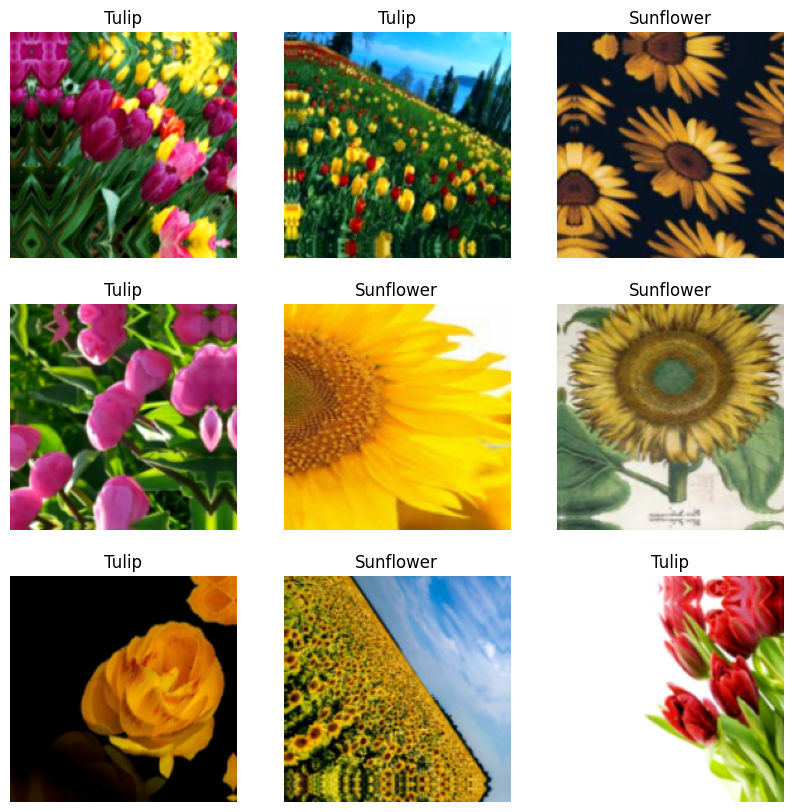

In [4]:
# Visualisasi Sampel

import matplotlib.pyplot as plt

# Gunakan class_names dari ds_filtered, bukan ds_full
class_names = ds_filtered.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = tf.argmax(labels[i]).numpy()  # Konversi dari one-hot ke indeks kelas
        plt.title(class_names[class_index])
        plt.axis("off")


In [5]:
# Hitung Gambar tiap Kelas

import os

base_path = "Proyek-Klasifikasi-Gambar/data/flower_images"
filtered_labels = ["Sunflower", "Tulip"]  # Sesuai class_names ds_filtered

for label in filtered_labels:
    folder_path = os.path.join(base_path, label)
    total_images = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".png"))
    ])
    print(f"{label}: {total_images} gambar")


Sunflower: 1000 gambar
Tulip: 1000 gambar


Distribusi label di train_ds:
Sunflower : 700 gambar
Tulip : 708 gambar


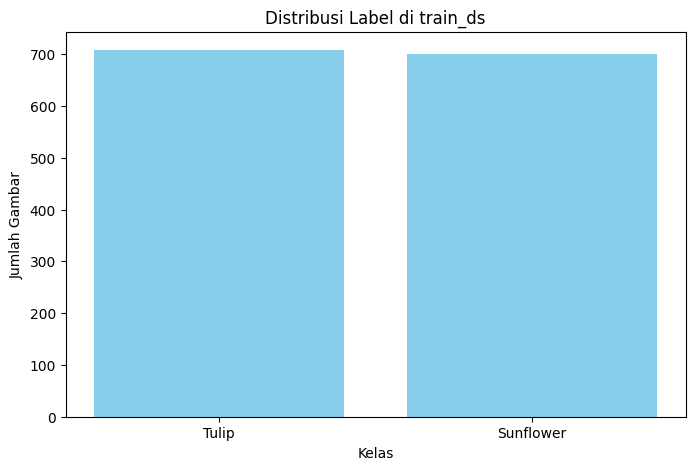

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Ambil class_names dari ds_filtered
class_names = ds_filtered.class_names

# Hitung distribusi label dari train_ds
class_counts = Counter()
for _, labels in train_ds.unbatch():
    class_index = tf.argmax(labels).numpy()  # konversi one-hot ke indeks
    class_counts[class_index] += 1

print("Distribusi label di train_ds:")
for i, class_name in enumerate(class_names):
    print(f"{class_name} : {class_counts[i]} gambar")

# Visualisasi distribusi label
labels = list(class_counts.keys())
counts = list(class_counts.values())
label_names = [class_names[i] for i in labels]

plt.figure(figsize=(8, 5))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Label di train_ds')
plt.show()


## Modelling

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input

# Muat model pretrained tanpa top layer
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # Freeze semua layer awal

# Ambil class_names dari ds_filtered
class_names = ds_filtered.class_names
num_classes = len(class_names)

# Bangun model akhir
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Jumlah kelas menyesuaikan
])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,353,474 (62.38 MB)

 Trainable params: 1,638,786 (6.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Ekstraksi Fitur dari Layer Tengah

from tensorflow.keras.models import Model

# Pastikan base_model sudah didefinisikan dengan input shape sesuai filtered dataset
# Ambil fitur dari layer tengah (contoh: block4_pool)
intermediate_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('block4_pool').output
)

# Ambil 1 batch dari train_ds
for images, _ in train_ds.take(1):  # hanya ambil images, abaikan label
    features = intermediate_model(images)
    print("Shape fitur:", features.shape)  # contoh: (32, 11, 11, 512)


I0000 00:00:1753878064.262300      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Shape fitur: (32, 11, 11, 512)


## Evaluasi dan Visualisasi

In [9]:
import tensorflow as tf

# Dataset location
data_dir = "/kaggle/working/Proyek-Klasifikasi-Gambar/data/flower_images"

# Corrected class names
selected_classes = ["Sunflower", "Tulip"]

# Load filtered training dataset
ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    class_names=selected_classes,  
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

# Load filtered validation dataset
val_ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    class_names=selected_classes,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

# Class info
class_names = ds_filtered.class_names
num_classes = len(class_names)

print("Filtered classes:", class_names)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
Filtered classes: ['Sunflower', 'Tulip']


In [10]:
# Definisikan dan Kompilasi Model

from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np

# Ambil nama kelas dari dataset yang sudah difilter
class_names = ds_filtered.class_names
num_classes = len(class_names)

# Arsitektur CNN sederhana dan efisien
model = models.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),  # Sesuaikan dengan image_size dataset
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Output sesuai jumlah kelas yang difilter
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
# Setup Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

In [12]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Dataset path
data_dir = "/kaggle/working/Proyek-Klasifikasi-Gambar/data/flower_images"

# Pastikan nama class cocok dengan subdirektori
selected_classes = ["Sunflower", "Tulip"]

# Load filtered training dataset
train_ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    class_names=selected_classes,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

# Load filtered validation dataset
val_ds_filtered = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    class_names=selected_classes,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

# Ambil informasi class
class_names = train_ds_filtered.class_names
num_classes = len(class_names)

print("Filtered classes:", class_names)

# 🔍 Hitung class weights
train_labels = []
for _, label_batch in train_ds_filtered.unbatch():
    class_index = tf.argmax(label_batch).numpy()
    train_labels.append(class_index)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)

# Dictionary: {0: weight_for_Sunflower, 1: weight_for_Tulip}
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
Filtered classes: ['Sunflower', 'Tulip']
Class weights: {0: 1.0050251256281406, 1: 0.9950248756218906}


In [13]:
# Training Model

history = model.fit(
    train_ds_filtered,
    validation_data=val_ds_filtered,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weight_dict  # Bisa dihapus jika distribusi kelas seimbang
)


Epoch 1/10


I0000 00:00:1753878071.512603     120 service.cc:148] XLA service 0x7c673c00a2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753878071.513553     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5558 - loss: 288.4135

I0000 00:00:1753878074.709697     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6454 - loss: 99.1504 - val_accuracy: 0.8825 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8706 - loss: 0.3796 - val_accuracy: 0.8775 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9118 - loss: 0.2781 - val_accuracy: 0.9200 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9260 - loss: 0.2368 - val_accuracy: 0.9250 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9476 - loss: 0.1972 - val_accuracy: 0.9175 - val_loss: 0.3374 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9555 - loss: 0.1717 - val_accuracy: 0.9475 - val_loss: 0.1692 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9587 - loss: 0.1535 - val_accuracy: 0.9

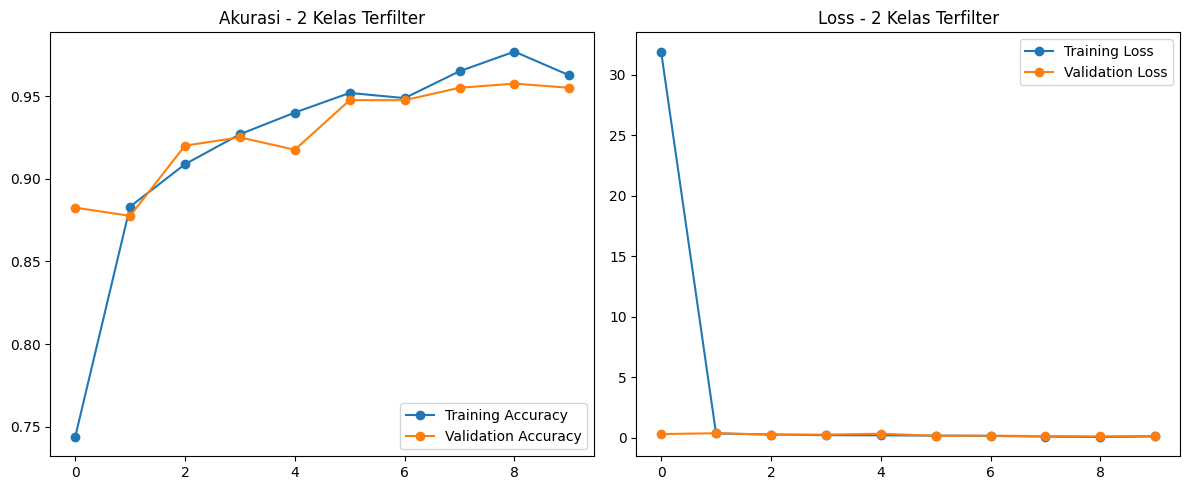

In [14]:
# Plot Akurasi dan Loss untuk filtered class

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Akurasi - 2 Kelas Terfilter')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Loss - 2 Kelas Terfilter')

plt.tight_layout()
plt.show()


In [15]:
# Evaluasi pada Testing Set - filtered class

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Akurasi pada test set (2 kelas terfilter): {test_accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9487 - loss: 0.1165
Akurasi pada test set (2 kelas terfilter): 94.23%


## Konversi Model

In [16]:
import os
import tensorflow as tf
import numpy as np

# Buat direktori output
output_dir = "saved_models_filtered"
os.makedirs(output_dir, exist_ok=True)

# Lokasi penyimpanan SavedModel
savedmodel_path = os.path.join(output_dir, "flower_model_filtered_saved")

# Ekspor model dalam format SavedModel (bukan .save)
model.export(savedmodel_path)
print("✅ SavedModel disimpan di:", savedmodel_path)

# Konversi ke TF-Lite
tflite_converter = tf.lite.TFLiteConverter.from_saved_model(savedmodel_path)
tflite_model = tflite_converter.convert()

tflite_path = os.path.join(output_dir, "flower_model_filtered.tflite")
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print("✅ TF-Lite disimpan di:", tflite_path)

# Konversi ke TFJS
!pip install -q tensorflowjs
tfjs_path = os.path.join(output_dir, "flower_model_filtered_tfjs")

# Pastikan tensorflowjs terinstal dan gunakan CLI untuk konversi
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    "{savedmodel_path}" "{tfjs_path}"

print("✅ TFJS disimpan di:", tfjs_path)


Saved artifact at 'saved_models_filtered/flower_model_filtered_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136785584698576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584700112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584699536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584700880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584700304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584701072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584700688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785584699344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785583325456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136785583326992: TensorSpec(shape=(), dtype=tf.r

W0000 00:00:1753878098.338767      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753878098.338801      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753878098.345889      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ TF-Lite disimpan di: saved_models_filtered/flower_model_filtered.tflite
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

## Inference (Optional)

1555158/1555158 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
52136/52136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


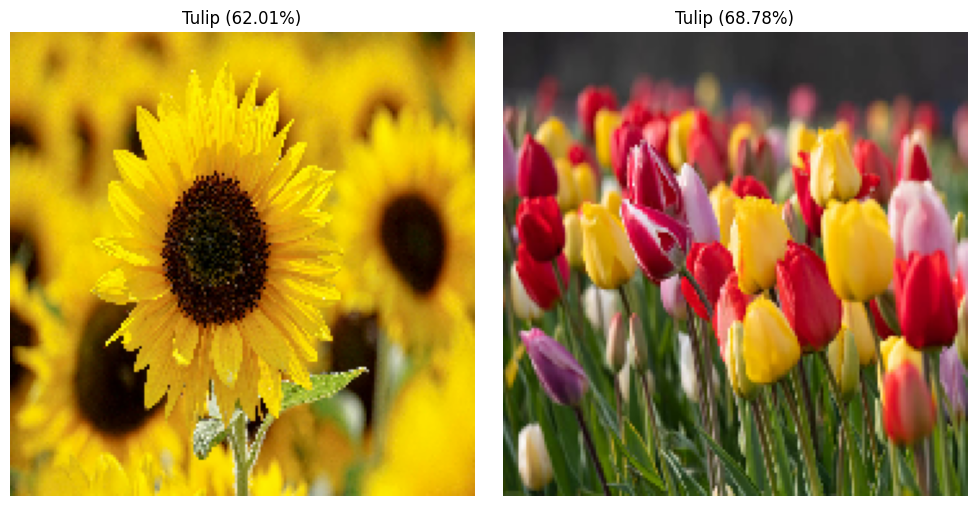

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Pastikan img_height dan img_width cocok dengan model training
img_height = 180
img_width = 180

# Pastikan class_names berasal dari ds_filtered agar sesuai dengan dua kelas aktif
class_names = ds_filtered.class_names

# URL gambar untuk inference (gunakan gambar relevan dengan 2 kelas ini)
image_urls = [
    "https://github.com/dannybudiman/Proyek-Klasifikasi-Gambar/blob/main/sunflower.jpg?raw=true",
    "https://github.com/dannybudiman/Proyek-Klasifikasi-Gambar/blob/main/tulip.jpg?raw=true"
]

# Prediksi dan visualisasi
plt.figure(figsize=(10, 5))
for i, url in enumerate(image_urls):
    # Ambil gambar dari URL
    img_path = tf.keras.utils.get_file(f"filtered_img_{i}.jpg", origin=url)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0  # normalisasi jika dibutuhkan
    img_array = tf.expand_dims(img_array, axis=0)

    # Prediksi
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = np.max(predictions[0])

    # Visualisasi
    ax = plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence*100:.2f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
import shutil
import os

# Jalur direktori hasil training dan data (pastikan path sudah ada)
model_dir = "/kaggle/working/saved_models_filtered"

# Kompres masing-masing direktori ke dalam ZIP
shutil.make_archive("saved_models_filtered_zip", "zip", model_dir)

print("✅ Kompresi selesai. File zip tersedia di /kaggle/working")


✅ Kompresi selesai. File zip tersedia di /kaggle/working
